# Introduction

We can fine-tune BART to help classify new datasets. Here we are going to use the Hugging Face transformers pipeline again, but train on a very small dataset (~10 examples/country). We will see results almost comparable with training from scratch on the full dataset with 100s or 1000s of names from each country.

The idea is that BART, during pre-training, has learned a lot about language, and with just a few examples, we should be able to get good generalization.

**Requries**
- names_balanced_train.csv
- names_balanced_test.csv

In [ ]:
!pip install transformers

# Loading the data.

Here we have the usual includes and data loading. Here, I'm using special versions of the names CSV file that have been resampled to be balanced for each of the 9 countries.

In [ ]:
import torch
import pandas as pd
from transformers import BartTokenizer, BartForSequenceClassification

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data from names.csv
train_data_full = pd.read_csv('names_balanced_train.csv',header=None,names=["name","country"])
test_data = pd.read_csv('names_balanced_test.csv',header=None,names=["name","country"])

We resample the data to use only a few examples from each country. Here the entire training dataset is so small that we can print out the full training data of <100 names (about 11/country) to look over.

In [ ]:
# Shuffle & Subsample the data
train_data = train_data_full.sample(frac=0.0055)
print(f"\nTraining on {len(train_data)} examples\n")

print(train_data.sort_values(by=["country"]).to_string())


Training on 99 examples

               name     country
1246       Unsworth     English
1494          Saleh     English
1740          Bloom     English
871            Donn     English
1611         Evrard     English
1094        Bithell     English
1972       Benjamin     English
1795    Ravenscroft     English
551          Durand     English
1199        Maguire     English
247        Maddocks     English
2039       Faucheux      French
3026         Fabron      French
2863       Rousseau      French
3157      Pettigrew      French
2217       Gosselin      French
2470      Delacroix      French
2061        Herbert      French
2558       Levesque      French
2808       Deforest      French
3832       Levesque      French
2923          Reyer      French
2174      Beauchene      French
2895    Archambault      French
4931           Papp      German
5512         Mohren      German
5823         Stueck      German
4898      Heinrichs      German
5668        Stenger      German
4996          

# Training

Here we use the BART pre-trained transformer architecture. Here, we are using a "pure" part that has only gone through the generative pre-training, but no supervised fine-tuning.

The `BartForSequenceClassification` will load a special Hugging Face pipeline that already has a classification output for us to train. When we load it, Hugging Face actually gives us an explicit reminder that this model only has valid weights for the BART encoding, and that we still need to train the classification weights.

In [ ]:
# Load BART tokenizer and model
num_countries = train_data['country'].nunique()
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartForSequenceClassification.from_pretrained('facebook/bart-large', num_labels=num_countries)
mode = model.to(device)


Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.out_proj.weight', 'classification_head.out_proj.bias', 'classification_head.dense.bias', 'classification_head.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We need to use the `tokenizer` that BART expects to turn our names into tokens that BART understands (above you can see that loading the `bart-large` model returns a tokenizer to use). We also need to create a one-hot encoding of the country labels.

In [ ]:
# Convert country column to one-hot encoding
one_hot_train = pd.get_dummies(train_data['country'])
one_hot_test = pd.get_dummies(test_data['country'])

# Tokenize names and convert to PyTorch dataset
inputs_train = tokenizer(list(train_data['name']), return_tensors='pt', padding=True)
labels_train = torch.tensor(one_hot_train.values, dtype=torch.float32)
dataset_train = torch.utils.data.TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
inputs_test = tokenizer(list(test_data['name']), return_tensors='pt', padding=True)
labels_test = torch.tensor(one_hot_test.values, dtype=torch.float32)
dataset_test = torch.utils.data.TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)


Now that we have the data and labels encoded, it's time to train. Recall from last week that training on the entire dataset (from scratch) gave us between 65-70% testing accuracy -- but that needed 100s or even 1000s of instances of labeled name data. How well can we do with only about 10 examples for each country, but backed by the power of BART?

In [ ]:

# Define training parameters
epochs = 10
batch_size = 64
learning_rate = 1e-4

# Train model
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

print(f"\nTraining on {len(train_data)} examples\n")
print("Num. Parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

for epoch in range(epochs):
    # Compute average loss after 100 steps
    avg_loss = 0
    for step, batch in enumerate(data_loader_train):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        avg_loss += loss.item()
        if step % 100 == 0:
            print(f"Step {step}/{len(data_loader_train)} Loss {loss} Avg Train Loss {avg_loss / (step + 1)}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss = avg_loss / len(data_loader_train)
    # Print loss after every epoch
    print(f"Epoch {epoch+1} Test Loss {loss}")
    # Compute accuracy after every epoch
    correct = 0
    total = 0
    for step, batch in enumerate(data_loader_test):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted = torch.argmax(outputs[0], dim=1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    print(f"Test Accuracy {100*correct/total}%\n")

# Save model
model.save_pretrained('fine-tuned-bart_countries')


Training on 99 examples

Num. Parameters: 407350281
Step 0/155 Loss 0.7047230005264282 Avg Train Loss 0.7047230005264282
Step 100/155 Loss 0.05723179876804352 Avg Train Loss 0.13394322591179078
Epoch 1 Test Loss 0.10967061162715958
Test Accuracy 70.33333333333333%

Step 0/155 Loss 0.017574889585375786 Avg Train Loss 0.017574889585375786


KeyboardInterrupt: ignored

This is actually some of the best accuracy we've seen on this dataset! To be fair, this is a 40,000,000 parameter model ... but, thanks to generative pre-training, we only need a few samples to train the model on our task.

You can try to train on the entire dataset on the pre-trained BART model to see how well you do, but remember 100% accuracy is impossible as some names show up in multiple countries ("Bach" is both German and Viennese). Personally, I was able to see results in the high 70s, but that took lots of data. For many cases, I would only need to label 100x fewer examples if it only meant losing a little bit of accuracy.

# Testing & Evaluation

We can load our trained version of the BART classification model if we like:

In [ ]:
# Load the model
# model = BartForSequenceClassification.from_pretrained('fine-tuned-bart_countries')
# model.to(device)

First, we can compute the overall testing accuracy:

In [ ]:
model.eval()
correct = 0
total = 0
for step, batch in enumerate(data_loader_test):
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    predicted = torch.argmax(outputs[0], dim=1)
    total += labels.size(0)
    correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

print(f"Accuracy {correct/total}")

Accuracy 0.7033333333333334


We can try some example names:

In [ ]:
# Test model on new names
new_names = ["Stephen", "Krzyzewski", "Satoshi", "Nguyen", "Rivera", "Monet"]
inputs = tokenizer(new_names, return_tensors='pt', padding=True)
outputs = model(inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'].to(device))
predicted = torch.argmax(outputs[0], dim=1)
for i in range(len(new_names)):
  print(f"{new_names[i]}: {one_hot_train.columns[predicted[i].item()]}")

Stephen: English
Krzyzewski: Polish
Satoshi: Japanese
Nguyen: Vietnamese
Rivera: Spanish
Monet: French


And we can look at our overall confusion matrix:

tensor([[174.,  17.,   6.,   1.,   0.,   0.,   2.,   0.,   0.],
        [ 51., 130.,  11.,   0.,   0.,   2.,   1.,   0.,   5.],
        [ 51.,  16., 124.,   2.,   0.,   0.,   3.,   4.,   0.],
        [  2.,   3.,   1., 178.,   0.,   0.,   3.,  13.,   0.],
        [ 13.,   0.,   0.,  17., 155.,   4.,   1.,  10.,   0.],
        [ 19.,   0.,   0.,   0.,  10., 120.,   0.,   0.,  51.],
        [ 21.,   8.,   0.,   4.,  15.,   0., 147.,   0.,   5.],
        [ 26.,  15.,   0.,  27.,   4.,   0.,   0., 128.,   0.],
        [  0.,  13.,   0.,  16.,   0.,   0.,   0.,   0., 171.]])


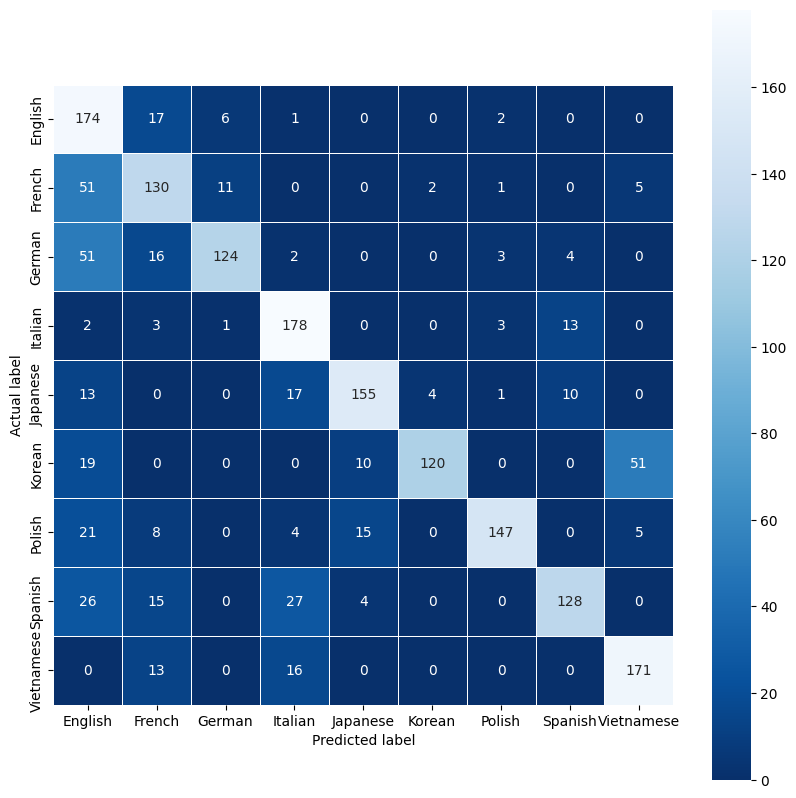

In [ ]:
# Make confusion matrix
confusion_matrix = torch.zeros(len(one_hot_test.columns), len(one_hot_test.columns))
for step, batch in enumerate(data_loader_test):
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    predicted = torch.argmax(outputs[0], dim=1)
    for i in range(len(predicted)):
        confusion_matrix[torch.argmax(labels[i])][predicted[i]] += 1

print(confusion_matrix)

# Plot confusion matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=one_hot_train.columns, yticklabels=one_hot_train.columns)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


Of course, even BART with supervised fine-tuning is still not 100% accurate, but, to me, all the results look very good even. Honestly, the results look stellar if you keep in mind how little training data we had (you should try going down to 30-50 samples and see how well it does still). Exploiting generative pre-training approaches like GPT and BART can be a big win for ML tasks, where large datasets are not possible.